In [1]:
import numpy as np
from torch import nn
from torch.nn import functional as F
import torch
from torch import optim
from torchvision import datasets,transforms
from torchinfo import summary
import albumentations as A
from albumentations.pytorch import ToTensorV2

from transformations import (train_transforms,test_transforms,no_transforms)

from trainer import Trainer
from tester import Tester
from utlis import visualize_data,show_misclassified_images,device,is_cuda
from viz import plot_class_distribution, plot_confusion_matrix, plot_curves
from dataloader import CIFAR10Dataset,CIFAR10DataLoader
from models import ConvLayer,TransBlock,DepthwiseConvLayer


# Augmentation
atrain_dataset = CIFAR10Dataset(root='../data/',train=True,Atransforms=train_transforms,download=False)
atest_dataset  = CIFAR10Dataset(root='../data/',train=False,Atransforms=test_transforms,download=False)
acifar = CIFAR10DataLoader(batch_size=512,is_cuda_available=True)
atrain_loader, atest_loader = acifar.get_loader(atrain_dataset,atest_dataset)


# No Augmentation
train_dataset = CIFAR10Dataset(root='../data/',train=True,Atransforms=no_transforms,download=False)
test_dataset  = CIFAR10Dataset(root='../data/',train=False,Atransforms=no_transforms,download=False)
cifar = CIFAR10DataLoader(batch_size=512,is_cuda_available=True)
train_loader, test_loader = cifar.get_loader(train_dataset,test_dataset)

C:\Users\muthu\Documents\TSAI\session 9\utlis.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


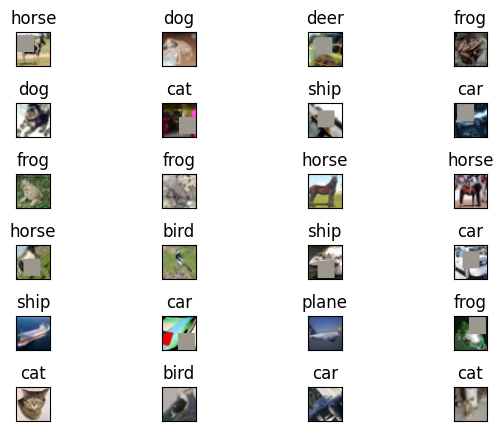

In [2]:
visualize_data(atrain_loader,classes=acifar.classes,num_figures=24)

In [3]:
# visualize_data(train_loader,classes=acifar.classes,num_figures=24)

In [4]:
dp_rate = 0.12
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = ConvLayer(inc=3,outc=8,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        
        self.conv2 = ConvLayer(         inc=8,outc=16,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        self.dep2  = DepthwiseConvLayer(inc=8,outc=16,p=1,s=1,dp_rate=dp_rate)
        self.dil2  = ConvLayer(         inc=8,outc=16,k=3,p=2,s=1,d=2,dp_rate=dp_rate)

        self.conv3 = ConvLayer(         inc=16,outc=32,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        self.dep3  = DepthwiseConvLayer(inc=16,outc=32,p=1,s=1,dp_rate=dp_rate)
        self.dil3  = ConvLayer(         inc=16,outc=32,k=3,p=2,s=1,d=2,dp_rate=dp_rate)

        self.trans4 = TransBlock(56,16,p=0,s=2)


        self.conv5 = ConvLayer(16,32,k=3,p=1,s=1,d=1,dp_rate=dp_rate)

        self.conv6 = ConvLayer(         inc=32,outc=48,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        self.dep6  = DepthwiseConvLayer(inc=32,outc=48,p=1,s=1,dp_rate=dp_rate)
        self.dil6  = ConvLayer(         inc=32,outc=48,k=3,p=2,s=1,d=2,dp_rate=dp_rate)

        self.conv7 = ConvLayer(         inc=48,outc=56,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        self.dep7  = DepthwiseConvLayer(inc=48,outc=56,p=1,s=1,dp_rate=dp_rate)
        self.dil7  = ConvLayer(         inc=48,outc=56,k=3,p=2,s=1,d=2,dp_rate=dp_rate)
      
        self.trans8 = TransBlock(136,24,p=0,s=2)

        
        self.conv9 = ConvLayer(24,40,k=3,p=1,s=1,d=1,dp_rate=dp_rate)

        self.conv10 = ConvLayer(         inc=40,outc=48,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        self.dep10  = DepthwiseConvLayer(inc=40,outc=48,p=1,s=1,dp_rate=dp_rate)
        self.dil10  = ConvLayer(         inc=40,outc=48,k=3,p=4,s=1,d=4,dp_rate=dp_rate)


        self.conv_ = ConvLayer(         inc=48,outc=48,k=3,p=1,s=1,d=1,dp_rate=dp_rate)
        self.dep_  = DepthwiseConvLayer(inc=48,outc=48,p=1,s=1,dp_rate=dp_rate)
        self.dil_  = ConvLayer(         inc=48,outc=48,k=3,p=4,s=1,d=4,dp_rate=dp_rate)

        self.trans11 = TransBlock(88,40,p=0,s=1)
        self.trans12 = TransBlock(40,20,p=0,s=1)
        self.out = TransBlock(inc=20,outc=10,p=0,s=1)
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        
    
    def forward(self,x):        
        x0 = self.conv1(x)
        x1 = self.dep2(x0) + self.conv2(x0) + self.dil2(x0) 
        x2 = self.dep3(x1) + self.conv3(x1) + self.dil3(x1) 
        x3 = torch.concat((x0,x1,x2),dim=1)
        x4 = self.trans4(x3)

        x5 = self.conv5(x4)
        x6 = self.conv6(x5) + self.dep6(x5) + self.dil6(x5)
        x7 = self.conv7(x6)+ self.dep7(x6)+ self.dil7(x6)
        x8 = torch.concat((x5,x6,x7),dim=1)
        x9  = self.trans8(x8)

        x10 = self.conv9(x9)
        x11 = self.conv10(x10) + self.dep10(x10) + self.dil10(x10)
        x11 = self.conv_(x11) + self.dep_(x11) + self.dil_(x11)
        x12 = torch.concat((x10,x11),dim=1)
        x  = self.trans11(x12)

        x  = self.trans12(x)
        x = self.gap(x)

        x = self.out(x)
        return  F.log_softmax(x.view(-1,10), dim=1)

model = Net().to(device)
summary(model,input_size=(1,3,32,32),device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─ConvLayer: 1-1                         [1, 8, 32, 32]            --
│    └─Sequential: 2-1                   [1, 8, 32, 32]            --
│    │    └─Conv2d: 3-1                  [1, 8, 32, 32]            216
│    │    └─BatchNorm2d: 3-2             [1, 8, 32, 32]            16
│    │    └─ReLU: 3-3                    [1, 8, 32, 32]            --
│    │    └─Dropout2d: 3-4               [1, 8, 32, 32]            --
├─DepthwiseConvLayer: 1-2                [1, 16, 32, 32]           --
│    └─Sequential: 2-2                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-5                  [1, 8, 32, 32]            72
│    │    └─Conv2d: 3-6                  [1, 16, 32, 32]           128
│    │    └─ReLU: 3-7                    [1, 16, 32, 32]           --
│    │    └─BatchNorm2d: 3-8             [1, 16, 32, 32]           32
│    │    └─D

In [ ]:
prev_test_loss = float('inf')

import os
if os.path.isfile(r"C:\Users\muthu\Documents\TSAI\session 9\bmodels\model5.pth"): model.load_state_dict(torch.load(r"C:\Users\muthu\Documents\TSAI\session 9\bmodels\model5.pth"))


optimizer = optim.SGD(params=model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=3)
criterion = nn.NLLLoss()
trainer = Trainer(model=model, train_loader=atrain_loader, optimizer=optimizer, criterion=criterion, device=device)
tester = Tester(model=model, test_loader=atest_loader,criterion=criterion, device=device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(obj=model.state_dict(),f='./bmodels/model5.pth')
    scheduler.step(test_loss)

EPOCH = 1 | LR = 0.1 | Loss = 1.73 | Batch = 97 | Accuracy = 26.40: 100%|███| 98/98 [00:40<00:00,  2.41it/s]


Test set: Average loss: 0.0032, Accuracy: 3913/10000 (39.13%)


EPOCH = 2 | LR = 0.1 | Loss = 1.76 | Batch = 97 | Accuracy = 35.34: 100%|███| 98/98 [00:40<00:00,  2.41it/s]


Test set: Average loss: 0.0029, Accuracy: 4401/10000 (44.01%)


EPOCH = 3 | LR = 0.1 | Loss = 1.61 | Batch = 97 | Accuracy = 38.82: 100%|███| 98/98 [00:40<00:00,  2.43it/s]


Test set: Average loss: 0.0028, Accuracy: 4818/10000 (48.18%)


EPOCH = 4 | LR = 0.1 | Loss = 1.62 | Batch = 97 | Accuracy = 41.47: 100%|███| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0026, Accuracy: 5253/10000 (52.53%)


EPOCH = 5 | LR = 0.1 | Loss = 1.42 | Batch = 97 | Accuracy = 44.54: 100%|███| 98/98 [00:41<00:00,  2.37it/s]


Test set: Average loss: 0.0025, Accuracy: 5272/10000 (52.72%)


EPOCH = 6 | LR = 0.1 | Loss = 1.49 | Batch = 97 | Accuracy = 46.55: 100%|███| 98/98 [00:40<00:00,  2.39it/s]


Test set: Average loss: 0.0023, Accuracy: 5711/10000 (57.11%)


EPOCH = 7 | LR = 0.1 | Loss = 1.38 | Batch = 97 | Accuracy = 48.08: 100%|███| 98/98 [00:40<00:00,  2.40it/s]


Test set: Average loss: 0.0022, Accuracy: 6005/10000 (60.05%)


EPOCH = 8 | LR = 0.1 | Loss = 1.37 | Batch = 97 | Accuracy = 49.99: 100%|███| 98/98 [00:40<00:00,  2.41it/s]


Test set: Average loss: 0.0021, Accuracy: 6301/10000 (63.01%)


EPOCH = 9 | LR = 0.1 | Loss = 1.32 | Batch = 97 | Accuracy = 51.26: 100%|███| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0020, Accuracy: 6407/10000 (64.07%)


EPOCH = 10 | LR = 0.1 | Loss = 1.22 | Batch = 97 | Accuracy = 53.14: 100%|██| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0019, Accuracy: 6692/10000 (66.92%)


EPOCH = 11 | LR = 0.1 | Loss = 1.25 | Batch = 97 | Accuracy = 53.93: 100%|██| 98/98 [00:40<00:00,  2.41it/s]


Test set: Average loss: 0.0018, Accuracy: 6812/10000 (68.12%)


EPOCH = 12 | LR = 0.1 | Loss = 1.27 | Batch = 97 | Accuracy = 54.72: 100%|██| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0017, Accuracy: 6894/10000 (68.94%)


EPOCH = 13 | LR = 0.1 | Loss = 1.36 | Batch = 97 | Accuracy = 55.72: 100%|██| 98/98 [00:40<00:00,  2.41it/s]


Test set: Average loss: 0.0017, Accuracy: 6926/10000 (69.26%)


EPOCH = 14 | LR = 0.1 | Loss = 1.21 | Batch = 97 | Accuracy = 56.94: 100%|██| 98/98 [00:40<00:00,  2.41it/s]


Test set: Average loss: 0.0016, Accuracy: 7163/10000 (71.63%)


EPOCH = 15 | LR = 0.1 | Loss = 1.11 | Batch = 97 | Accuracy = 57.82: 100%|██| 98/98 [00:40<00:00,  2.41it/s]


Test set: Average loss: 0.0016, Accuracy: 7114/10000 (71.14%)


EPOCH = 16 | LR = 0.1 | Loss = 1.27 | Batch = 97 | Accuracy = 58.14: 100%|██| 98/98 [00:40<00:00,  2.43it/s]


Test set: Average loss: 0.0016, Accuracy: 7233/10000 (72.33%)


EPOCH = 17 | LR = 0.1 | Loss = 1.11 | Batch = 97 | Accuracy = 58.95: 100%|██| 98/98 [00:40<00:00,  2.43it/s]


Test set: Average loss: 0.0015, Accuracy: 7300/10000 (73.00%)


EPOCH = 18 | LR = 0.1 | Loss = 1.10 | Batch = 97 | Accuracy = 59.41: 100%|██| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0015, Accuracy: 7323/10000 (73.23%)


EPOCH = 19 | LR = 0.1 | Loss = 1.21 | Batch = 97 | Accuracy = 60.05: 100%|██| 98/98 [00:40<00:00,  2.43it/s]


Test set: Average loss: 0.0015, Accuracy: 7384/10000 (73.84%)


EPOCH = 20 | LR = 0.1 | Loss = 1.17 | Batch = 97 | Accuracy = 60.11: 100%|██| 98/98 [00:40<00:00,  2.43it/s]


Test set: Average loss: 0.0015, Accuracy: 7391/10000 (73.91%)


EPOCH = 21 | LR = 0.1 | Loss = 1.06 | Batch = 97 | Accuracy = 60.85: 100%|██| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0015, Accuracy: 7464/10000 (74.64%)


EPOCH = 22 | LR = 0.1 | Loss = 1.04 | Batch = 97 | Accuracy = 61.35: 100%|██| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0015, Accuracy: 7419/10000 (74.19%)


EPOCH = 23 | LR = 0.1 | Loss = 1.12 | Batch = 97 | Accuracy = 61.97: 100%|██| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0014, Accuracy: 7510/10000 (75.10%)


EPOCH = 24 | LR = 0.1 | Loss = 1.09 | Batch = 97 | Accuracy = 61.91: 100%|██| 98/98 [00:40<00:00,  2.41it/s]


Test set: Average loss: 0.0014, Accuracy: 7587/10000 (75.87%)


EPOCH = 25 | LR = 0.1 | Loss = 1.07 | Batch = 97 | Accuracy = 62.23: 100%|██| 98/98 [00:40<00:00,  2.40it/s]


Test set: Average loss: 0.0014, Accuracy: 7623/10000 (76.23%)


EPOCH = 26 | LR = 0.1 | Loss = 0.97 | Batch = 97 | Accuracy = 62.60: 100%|██| 98/98 [00:40<00:00,  2.41it/s]


Test set: Average loss: 0.0013, Accuracy: 7664/10000 (76.64%)


EPOCH = 27 | LR = 0.1 | Loss = 1.01 | Batch = 97 | Accuracy = 62.64: 100%|██| 98/98 [00:40<00:00,  2.41it/s]


Test set: Average loss: 0.0013, Accuracy: 7694/10000 (76.94%)


EPOCH = 28 | LR = 0.1 | Loss = 0.94 | Batch = 97 | Accuracy = 62.96: 100%|██| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0013, Accuracy: 7733/10000 (77.33%)


EPOCH = 29 | LR = 0.1 | Loss = 0.95 | Batch = 97 | Accuracy = 63.39: 100%|██| 98/98 [00:40<00:00,  2.41it/s]


Test set: Average loss: 0.0013, Accuracy: 7693/10000 (76.93%)


EPOCH = 30 | LR = 0.1 | Loss = 1.11 | Batch = 54 | Accuracy = 63.71:  56%|█ | 55/98 [00:32<00:07,  5.73it/s]

In [ ]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

In [ ]:
images, predictions, labels =  tester.get_misclassified_images()
show_misclassified_images(images[:15],predictions[:15],labels[:15],cifar.classes)
plot_class_distribution(train_loader,cifar.classes)
plot_confusion_matrix(model,atest_loader,device,cifar.classes)

In [ ]:

plot_confusion_matrix(model,atrain_loader,device,cifar.classes)